In [1]:
import torch
import torch.nn as nn
import gym
from itertools import count
import numpy as np
import random
import torch.nn.functional as F
import itertools

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2']
env = gym.make(envs[0]).unwrapped

discrete_actions = True
#TODO
#parralel fitness measuring
from helper import *
%matplotlib inline
import matplotlib.pyplot as plt
import random

#seed = 69
#random.seed(seed)
#np.random.seed(seed)
#torch.cuda.manual_seed_all(seed)
#torch.manual_seed(seed)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class Creature(nn.Module):
    def __init__(self):
        super(Creature, self).__init__()
    
        self.layer1 = nn.Linear(env.observation_space.shape[0], 6)
        self.layer2 = nn.Linear(6, 6)
        
        if discrete_actions:
            self.layer3 = nn.Linear(6, env.action_space.n)
        else:
            self.layer3 = nn.Linear(6, env.action_space.shape[0])
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose1d((len(get_params(Creature()))*2), 128, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(True))
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose1d(32, 16, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(16),
            nn.ReLU(True))
        
        
        self.layer5 = nn.Linear(16*13, len(get_params(Creature())))
        
    def forward(self, mom,dad,a):
        out = torch.cat([mom,dad]).unsqueeze(0)
        out = out.unsqueeze(-1)
        #print(out.shape)
        out = self.layer1(out)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = self.layer4(out)
        #print(out.shape)
        out = out.view(out.size(0),out.size(1)*out.size(2))
        out = self.layer5(out)
        z = torch.zeros(mom.shape).to(device)
        mom_func = (mom+(torch.tanh(out+3)*a)) * (torch.min(mom,z)/mom+0.0001)
        dad_func = (dad+(torch.tanh(-out+3)*a)) * (torch.max(dad,z)/(dad+0.0001))
        out = mom_func + dad_func
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 16, 5, stride=1, padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, 8, 5, stride=1, padding=0),  
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer2 = nn.Sequential(
            nn.Conv1d(8, 32, 5, stride=1,padding=0),  
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 16, 5, stride=1,padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer3 = nn.Sequential(
            nn.Conv1d(16, 32, 5, stride=1,padding=0),  
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 16, 5, stride=1,padding=0),  
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool1d(2, stride=1))
        
        self.layer4 = nn.Linear(16*59, 32)
        self.layer5 = nn.Sequential(       
            nn.Linear(32, 1))#,
            #nn.Sigmoid())
    def forward(self, out):
        
        out = out.unsqueeze(1)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),out.size(1)*out.size(2))
        
        out = self.layer4(out)
        out = self.layer5(out)
        
        
        return out
#gen = Generator().to(device)
#gen(torch.zeros([10,(len(get_params(Creature()))*2)]).to(device)).shape

#dis = Discriminator().to(device)
#dis(torch.zeros([10,len(get_params(Creature()))]).to(device)).shape    

In [3]:
def mate(m,d,mutation_rate_m,mutation_rate_d,child_mutation_rate,use_gen,mutation_scale=0.07):
    child = Creature()
    mom = (m)
    dad = (d)
    mutation_rate = np.min([mutation_rate_m,mutation_rate_d])
    #mom = mutate(mom,mutation_rate_m,mutation_scale)
    #dad = mutate(dad,mutation_rate_d,mutation_scale)
    mom = get_params(mom)
    dad = get_params(dad)
    if random.randint(0,100) < 40:
        #mut_gen = mutate(use_gen,0.1,0.1,start_layer = 11)
        mutation = np.random.choice([0.3, 0], mom.numel(),p=[mutation_rate,1-mutation_rate])
        mutation = torch.from_numpy(mutation).type('torch.FloatTensor').to(device)

        a = mutation
    else:
        a = 0.01
    generated = use_gen(mom,dad,a).squeeze(0)
    child = set_params(child,generated)

    child = mutate(child,child_mutation_rate,mutation_scale)
    #child = mutate(child,np.mean([mutation_rate_m,mutation_rate_d]),mutation_scale)
    
    return child

def mutate(creature,mutation_rate=0.2,scale = 0.07,start_layer = 0):
    if mutation_rate != 0:
        new = creature.__class__().to(device)
        new.load_state_dict(creature.state_dict()) 
        for idx,p in enumerate(new.parameters()):
            if idx < start_layer:
                continue
            mutation = np.random.normal(scale = scale,size = p.data.shape)
            mutation *= np.random.choice([1, 0], p.data.shape,p=[mutation_rate,1-mutation_rate])
            mutation = torch.from_numpy(mutation).type('torch.FloatTensor').to(device)
            p.data += mutation
        return new
    else:
        return creature

def evolve(population,out_size,new_gen,old_gen,p_fitness,child_mutation_rate,mutation_rate,mutation_scale):
    pick_probabilities = get_pick_probabilities(p_fitness)
    choice = np.random.choice(pick_probabilities.size,out_size, p = pick_probabilities)
    new_population = []
    parent_fitness = []
    for p in range(out_size-1):
        first_choice = population[choice[p]]
        second_choice = population[choice[p+1]]
        par_fit = np.max([p_fitness[choice[p]],p_fitness[choice[p+1]]])
        
        use_gen = new_gen
        
        child = mate(first_choice,second_choice,
                     mutation_rate[choice[p]],mutation_rate[choice[p+1]],child_mutation_rate,use_gen,mutation_scale).to(device)
        
        parent_fitness.append(par_fit)
        new_population.append(child)
        
    child = mate(population[0],population[len(population)-1] 
                 ,mutation_rate[0],mutation_rate[len(population)-1],child_mutation_rate,use_gen,mutation_scale).to(device) 
    parent_fitness.append(np.max([p_fitness[0],p_fitness[len(p_fitness)-1]]))
    
    new_population.append(child)
    
    return new_population, np.array(parent_fitness)



In [4]:

def train_gan(population,p_fitness,batch_size = 20,n_epochs = 100):
    
        
    print(min_fit)
    
    p_fitness = torch.from_numpy(p_fitness).to(device).type("torch.cuda.FloatTensor")
    gen_error = 1000
    dis_error_fake = 1000
    dis_error_real = 1000
    e = 0
    
    gen_loss_all = []
    dis_loss_all = []
    rec_loss_all = []
    while True:
        e += 1
        if e >= n_epochs:
            break
        #shuffle arrays in unison
        ind = np.arange(len(population))
        np.random.shuffle(ind)
        population = np.array(population)[ind]
        p_fitness = p_fitness[ind]
        
        for i in range(len(population)//batch_size):

            gen_optimizer.zero_grad()
            dis_optimizer.zero_grad()
            
            real_batch = []
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
            
            #train discriminator on population
            if dis_error_real > 0.05:
                
                dis_out_r = dis(real_batch).squeeze(-1)
                #stack = [ranking[i*batch_size:(i*batch_size)+batch_size],torch.ones(batch_size).to(device)]
                #stack = torch.stack(stack)
                
                #dis_error_real = nn.BCELoss()(dis_out,
                    #ranking[i*batch_size:(i*batch_size)+batch_size])#torch.ones(batch_size).to(device))
                #dis_error_real = nn.BCELoss()(dis_out,stack.transpose(0,1))
                rank = p_fitness[i*batch_size:(i*batch_size)+batch_size]
                dis_error_real = nn.L1Loss()(dis_out_r,rank) 
                dis_error_real.backward()
                
        
            #train discriminator on generator output
            mom = []
            dad = []
            child = []
            for b in range(batch_size):
                m = get_params(random.choice(population))
                d = get_params(random.choice(population))
                #c_data = torch.cat([m,d]).unsqueeze(0)
                a = torch.from_numpy(np.random.rand(d.numel()) * 0.3).to(device).type("torch.cuda.FloatTensor")
                c = gen(m,d,a).squeeze(0)
                
                mom.append(m)
                dad.append(d)
                child.append(c)
            
            mom = torch.stack(mom).to(device)
            dad = torch.stack(dad).to(device)
            child = torch.stack(child).to(device)
            dis_out_f = dis(child).squeeze(-1)
            dis_error_fake = nn.L1Loss()(dis_out_f,torch.zeros(dis_out_f.shape).to(device))
            #if gen_error < 0.5:#dis_error_fake > 0.3:
            dis_error_fake.backward(retain_graph=True)

            dis_optimizer.step()        
            
            #train generator
            
            
            
            yeet = (torch.pow(torch.sub(dad,mom),2)*100)+1
            #yeet = nn.L1Loss()(mom,dad) + 1
            mom_loss = torch.mean((torch.pow(torch.sub(child,mom),2)*100)/yeet)     
            dad_loss = torch.mean((torch.pow(torch.sub(child,dad),2)*100)/yeet)
            child_error = (mom_loss + dad_loss) * 5
            
            
            #gen_error = nn.BCELoss()(dis_out_f,torch.ones(dis_out_f.shape).to(device))
            gen_error = -nn.L1Loss()(dis_out_f,torch.zeros(dis_out_f.shape).to(device))
            
            total_gen_error = gen_error # + child_error
            if e % 1 == 0:
                total_gen_error.backward()
                gen_optimizer.step()
            
        gen_loss_all.append(gen_error)
        dis_loss_all.append(dis_error_fake+dis_error_real)
        rec_loss_all.append(child_error)    
            
        #if e %  5 == 0:    
        #print("Discriminator loss real : {}".format(dis_error_real))
        #print("Discriminator loss generated : {}".format(dis_error_fake))
        #print("Generator loss : {}".format(gen_error))
        #print("Child error : {}".format(child_error*0.1))
        #print("")
    return gen_loss_all, dis_loss_all, rec_loss_all

starting training
[ 9. 10. 10. 46.]
46.0


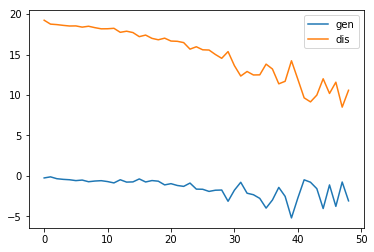

Generation 1  fitness : 46.0
#################################
[ 9.  9.  9. 10.  8. 13.]
13.0


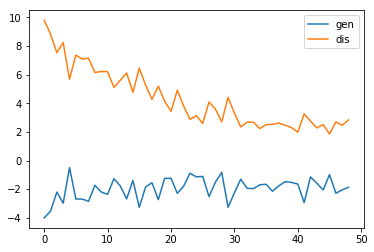

Generation 2  fitness : 13.0
#################################
[  9. 104.  86.  10.  10.  10.   9.   9.]
95.0


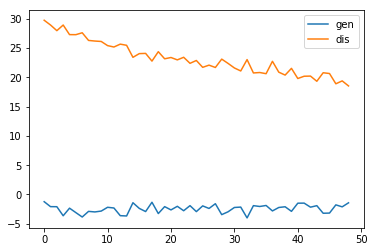

Generation 3  fitness : 104.0
#################################
[ 9. 10. 26. 57.  8. 10. 66.  8. 10.  9.]
61.5


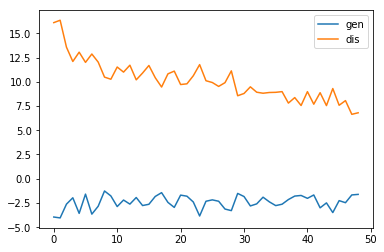

Generation 4  fitness : 66.0
#################################
[ 9. 62. 40. 10. 11. 10.  9. 10. 10.  8.]
51.0


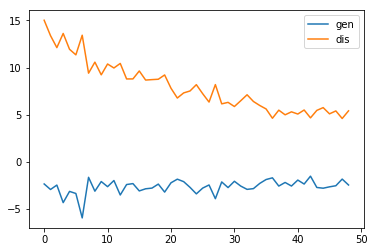

Generation 5  fitness : 62.0
#################################
[  9.  10.  10.  11.   9.  10.  22. 132.  16.   9.]
77.0


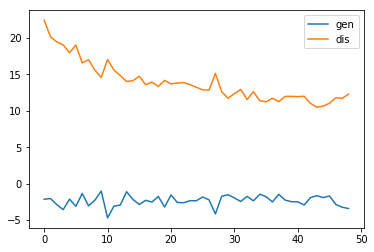

Generation 6  fitness : 132.0
#################################
[206. 242.  43.  22.  98. 270.  11.  11.  15.  10.]
256.0


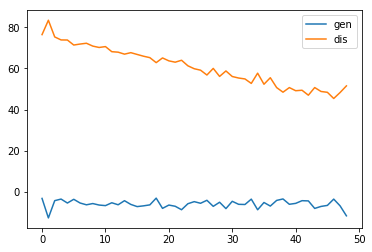

Generation 7  fitness : 270.0
#################################
[  16.    9.   42.   52.   17.   10.    9.  101. 1000.    9.]
550.5


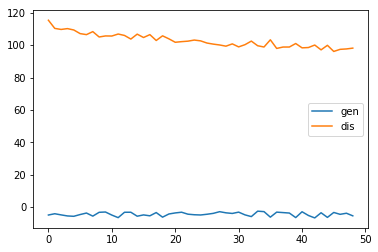

Generation 8  fitness : 1000.0
#################################
[   8.    9.   23.   13.  124.  118. 1000.  243.  134.   10.]
621.5


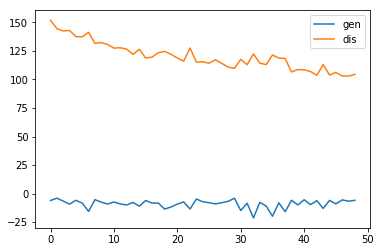

Generation 9  fitness : 1000.0
#################################
[ 15.  23.  48. 102. 160.  10.   9. 279.  21.  10.]
219.5


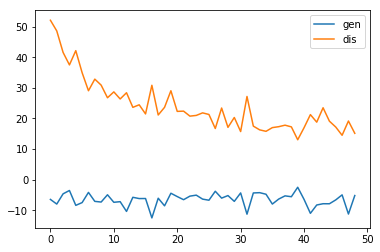

Generation 10  fitness : 279.0
#################################
[ 199.  171.   17.   38.   22. 1000.   22.  193.    9.    8.]
599.5


In [ ]:
#randomly inititialise starting population
population_size = 4
max_population = 10
batch_size = population_size
out_size = population_size
ranking = np.zeros([population_size])
parent_fitness = np.zeros([population_size])
population = []

for p in range(population_size):
    population.append(Creature().to(device))
    
old_population = population 

gen = Generator().to(device)
old_gen = gen
dis = Discriminator().to(device)

lr = 0.0005

print("starting training")
n_generations = 300


fit_bank = np.array([])
for i in range(n_generations):

    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=lr,betas=(0.5,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=lr,betas=(0.5,0.999))
    p_fitness, behavior_samples = measure_population_fitness(population,env,device,discrete_actions,
                                                             max_steps = 1000)
    
    print(p_fitness)
    #p_fitness = (p_fitness - np.min(p_fitness))/np.sqrt(np.var(p_fitness)+0.000001)

    #print(normed)
    if i == 0:
        old_fitness = p_fitness
    cat = np.concatenate([p_fitness,old_fitness])
    #min_fit = np.mean(np.sort(cat)[cat.size-cat.size//4:])
    min_fit = np.mean(np.sort(p_fitness)[p_fitness.size-p_fitness.size//4:])
    if i < 3:
        n_epochs = 50#i+1)
    elif i < 7:
        min_gen = 0.5
        2
        n_epochs = 50
    else:
        min_gen = 0.5
        
        n_epochs = 50
    fit_bank = np.array(old_population)[np.where(old_fitness>min_fit)]
    fit_bank_fitness = np.array(old_fitness)[np.where(old_fitness>min_fit)]
    
    new_population = population
    new_population = np.concatenate((population,fit_bank))
    new_fitness = p_fitness
    new_fitness = np.concatenate((p_fitness,fit_bank_fitness))
    #new_batch_size = batch_size+fit_bank.size
    #new_batch_size = new_population.size
    new_batch_size = batch_size
    #gan_loss_mul = 1/(np.max(p_fitness)-np.min(p_fitness))
    
    gen_loss, dis_loss,rec_loss = train_gan(population,p_fitness,
              batch_size =new_batch_size,n_epochs = n_epochs)
    
    plt.plot(gen_loss,label='gen')
    plt.plot(dis_loss,label='dis')
    #plt.plot(rec_loss,label='rec')
    #plt.ylim(0, 5)
    plt.legend()
    plt.show()
    
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness)],env,device,discrete_actions,
                                  render = True,max_steps = 200)
    
    child_mutation_rate = 0.1
    mutation_scale = 0.1
    #mutation_rate = 1+np.log(1-(p_fitness/np.max(p_fitness)))
    #mutation_rate = np.clip(mutation_rate, 0,0.9) + 0.1
    #norm_fit = p_fitness-np.min(p_fitness)
    #norm_fit = norm_fit / np.max(norm_fit)
    #mutation_rate = ((1-norm_fit)*0.2) + 0.1
    #print(mutation_rate)
    #normed = (1-(p_fitness - np.min(p_fitness))/((np.max(p_fitness)-np.min(p_fitness)))+0.00001)*0.1 + 0.001
    #print(normed)
    #mutation_rate = np.ones(p_fitness.shape) * 0.01
    mutation_rate = np.ones(p_fitness.shape) * 0.3
    #mutation_rate = (np.ones(p_fitness.shape) * 0.2 * (1-(p_fitness>=parent_fitness))) + 0.1
    #print(mutation_rate)
    if min_fit < 13:
        child_mutation_rate = 1
        mutation_rate = np.ones(p_fitness.shape)
        mutation_scale = 0.9
        
    if out_size < max_population:
        out_size+=2
        batch_size = out_size
    
    old_population = population
    old_fitness = p_fitness
    population, parent_fitness = evolve(population,out_size,gen,old_gen,p_fitness,child_mutation_rate,
                                        mutation_rate,mutation_scale)
    old_gen = gen
    
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness)))
    print("#################################")
